# Prereq notebook for Notebooks tutorial
This is the final step of the setup instructions here:  
https://github.com/TriggerMail/data_science/blob/master/docs/jupyter_setup/how_to_setup_jupyter.md

Follow the two bold numbered instructions below, and you should get a small dataframe and a bar chart if your setup is complete.   
Please reach out to Robert and/or Lema if you have issues troubleshooting, BEFORE class, as you won't be able to follow along without the setup completed.


## 1. replace the string with the path to your src directory:
make sure your trigger_mail/src file is up to date!

In [2]:
# path to src
src_path = '/src/trigger_mail/src'

## 2. In the menu bar above, go to Cell -> Run All
If everything is set up as needed, you should get no errors and all the cells should complete running under a minute

In [3]:
# this lets you save/run this notebook as if you have it saved in your src directory
import os
os.chdir(src_path)

In [4]:
%matplotlib inline
from remote_bootstrap import *
from gae_console import *
connect('triggeredmail')

from datetime import *
import pandas as pd
import matplotlib.pyplot as plt
import time

In [5]:
# import BQ
from bigquery.api import BigQueryApi

In [6]:
# fuction to get a list of live partner names
def new_get_all_active_partners():
    all_partners = GetPartners()()
    partners=[]
    for partner in all_partners: 
        if partner.is_live():  # check for live partners
            partners.append(partner.name)
    return partners

In [7]:
# function to extract results of BQ query into a pandas dataframe with the corresponding data types
def process_BQ_return(result, generate_DF=True):
    type_mapping = {'INTEGER': int, 'FLOAT': float, 'STRING': stringify, 'BOOLEAN': str2bool, 'TIMESTAMP': datetime.utcfromtimestamp}
    schema = [str(s['name']) for s in result['schema']['fields']]
    schema_type = [str(s['type']) for s in result['schema']['fields']]

    data= []
    for row in result['rows']:
        row_to_parse = row['f']
        row_list = []
        for i in range(len(row_to_parse)):
            if row_to_parse[i]['v'] is None:
                row_list.append(None)
            elif schema_type[i] != 'TIMESTAMP':
                row_list.append(type_mapping[schema_type[i]](row_to_parse[i]['v']))
            else:
                row_list.append(type_mapping[schema_type[i]](float(row_to_parse[i]['v'])))
        data.append(dict(zip(schema,row_list)))    
    
    if generate_DF:
        return pd.DataFrame(data)
    else:
        return data

In [18]:
# Monthly total email volumes for the past 24 months 
query_1 = """
SELECT
"%(PARTNER)s" partner,
year (created) year,
month(created) month,
--action,
count(distinct nqe) delivered_nqe
FROM Table_query(triggeredmail:%(PARTNER)s,"table_id contains 'delivered_20'")
WHERE created > {25_months_ago}
GROUP BY year, month
ORDER BY year desc, month desc
"""

my_query = """
SELECT 
"%(PARTNER)s" partner,
MONTH(created) created_month, 
COUNT(DISTINCT nqe)
FROM [triggeredmail:%(PARTNER)s.click_201611]
GROUP BY created_month
ORDER BY created_month
"""


In [9]:
# connect to bluecore-qa.  assumes you already have access. Talk to @james if not
BQ=BigQueryApi('bluecore-qa','tmp')

In [10]:
# pull the list of partners 
partners = new_get_all_active_partners()

In [42]:
len(partners)

403

In [29]:
# run the dummy query for a few partners
# this should take no more than a minute total, with a few rows printing out for each iteration
# for partner in  partners[10:15]:


# make a dataframe to save results
df_partners = pd.DataFrame()

# track progress
partners_remaining = len(partners)

for partner in  partners:
    
    # replace the template PARTNER string with the current partner name
    query= query_1 % {"PARTNER": partner}
    query = expand_straight_sql(query,partner)
    
    print 'partners remaining: ', partners_remaining

    # run the query
    try:
        result = BQ.query(query=query, expand_sql=False)
        df = process_BQ_return(result,True)
        df_partners = df_partners.append(df, ignore_index=True)
    except:
        print 'query failed for {}'.format(partner)
        

    df_partners.to_csv('/Users/jchen/Desktop/test_sql1.csv')  
    partners_remaining -= 1


2017-06-08 20:41:39.457391 query_by_job] Expanding sql to run against project (bluecore-qa)
2017-06-08 20:41:51.438046 _is_job_done] tmp: query job _vo9UojmY6OwKnW8Cpmsw9cIdScjtcM1KXS1L7dMKgjQh83nfrCl6MB6oJmooC_bDfKEG9r9Thg1EYkSHKmr1oLI_2Tmdo08C4rpvXEI7zMthnPeDvWVf1R3znKULVXPUO2cGZaeXfBoB3dtcQufRyWe_EQ449a0xLCXiP5oBQzyVP3T73Ws8QX14p8Pu1rPAbHEUubzPX5N3egRpqM9fRWxzaRaN0azhSUjn_UK2dBym_UYXT_thfLZsrGLeWpq done
2017-06-08 20:41:51.465083 _is_job_done] Query successfully completed on bluecore-qa at billing tier = 1
2017-06-08 20:41:51.945150 _get_query_results] tmp: total rows = 25
2017-06-08 20:41:51.973334 _get_query_results] tmp: getQueryResults done.
2017-06-08 20:41:52.067637 _get_query_results] Query on project: bluecore-qa, dataset: tmp processed 7444259657 bytes
2017-06-08 20:41:52.087602 query_by_job] Expanding sql to run against project (bluecore-qa)
2017-06-08 20:42:03.998381 _is_job_done] tmp: query job hXi029Q8c2nlhZBozpgm7HWSICBM2FQvtkYwBluH9NTNRGyLn_YUUX0pVbjWiE4nJowExjVjskcgy

In [30]:
# show the results - if you get a table with some partners and numbers below, you're good to go for BQ and pandas!
df_partners

,delivered_nqe,month,partner,year
0,473915,6,staples,2017
1,1783831,5,staples,2017
2,1564460,4,staples,2017
3,1583283,3,staples,2017
4,1646406,2,staples,2017
5,2143232,1,staples,2017
6,3292497,12,staples,2016
7,2958479,11,staples,2016
8,2473181,10,staples,2016
9,2322443,9,staples,2016


In [40]:
df_partners[df_partners.month].sum()

delivered_nqe                                             60683925
month                                                          264
partner          staplesstaplesstaplesstaplesstaplesstaplesstap...
year                                                         60468
dtype: object

In [31]:
df_partners.to_csv('/Users/jchen/Desktop/test.csv')

Next Steps


- run the basic query for ALL partners
- save the results to a all_data.csv file
- templetize query_2 and run for all partners (remember to add the {25_months_ago}
- save the results to a all_data_by_subaction.csv file


# Try plotting 
(if you don't plan to plot anything this doesnt HAVE to work but highly recommended)  
Plotting has some compatibilty issues with tmenv  
Following roberts' setup instructions should have gotten around this, reach out if you get errors


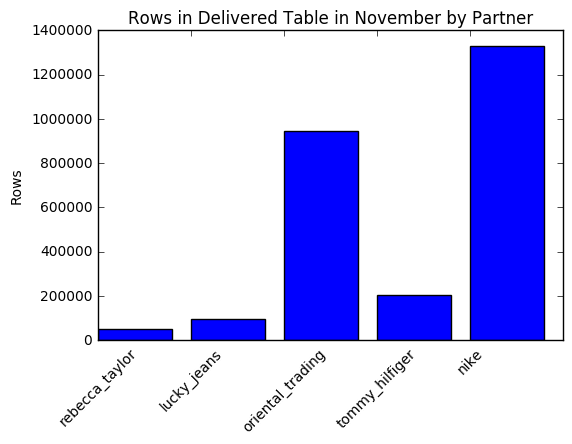

In [13]:
# tell plots to showup inline
%matplotlib inline

# set up plot area
fig = plt.figure()
ax = fig.add_subplot(111)

# data to plot
row_nums = list(df_partners['num'])

# data labels
xlabels = list(df_partners['partner'])

# x axis index
ind = np.arange(len(df_partners))

# bars
bars = ax.bar(ind, row_nums, color='blue')

# axes and labels
ax.set_ylabel('Rows')
ax.set_title('Rows in Delivered Table in November by Partner')
xtickNames = ax.set_xticklabels(xlabels)
plt.setp(xtickNames, rotation=45)

plt.show()

